In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
import string
import xarray as xr

import arke
from arke.cart import merc_map_grid, label_map

from common_defs import winters, nyr, winter_dates, datasets
from plot_utils import LCC_KW, trans, clev101, abs_plt_kw, iletters, div_cmap
import mypaths

from octant.core import TrackRun, OctantTrack, HOUR
from octant.misc import calc_all_dens, SUBSETS, DENSITY_TYPES
import octant
octant.__version__

'0.0.11'

In [2]:
plt.style.use('paperfig.mplstyle')

In [3]:
lsm = xr.open_dataarray(mypaths.era5_dir / 'lsm.nc').squeeze()
lsm.attrs['units'] = 1
lon2d, lat2d = np.meshgrid(lsm.longitude, lsm.latitude)

In [4]:
accacia_pl_datetime = datetime(2013, 3, 26, 12)

In [5]:
dset_dict = dict()
for dataset in datasets:
    dset_dict[dataset] = xr.open_mfdataset(getattr(mypaths, f'{dataset}_dir').glob(f'*{accacia_pl_datetime:%Y.%m.}*.nc'))

In [6]:
AXGR_KW = dict(axes_pad=0.5,
               cbar_location='right',
               cbar_mode='edge',
               cbar_pad=0.2,
               cbar_size='3%')

In [7]:
MERC_KW = {k: v for k, v in LCC_KW.items() if not k in ['clon', 'clat']}
MERC_KW['ticks'] = [5, 1]
MERC_KW['extent'] = [-10, 25, 68, 78]
cmap = plt.cm.PuOr_r
text_kw = dict(ha='center',
               va='center',
               fontsize='medium',
               path_effects=[PathEffects.withStroke(linewidth=3,
                                                    foreground='w')])

In [8]:
_toponyms = [
    dict(name='Svalbard', lon=15, lat=77.5),
    dict(name='Norway', lon=17, lat=69),
    dict(name='Fram\nStrait', lon=0, lat=77),
    dict(name='Norwegian\nSea', lon=5, lat=68.75),
]

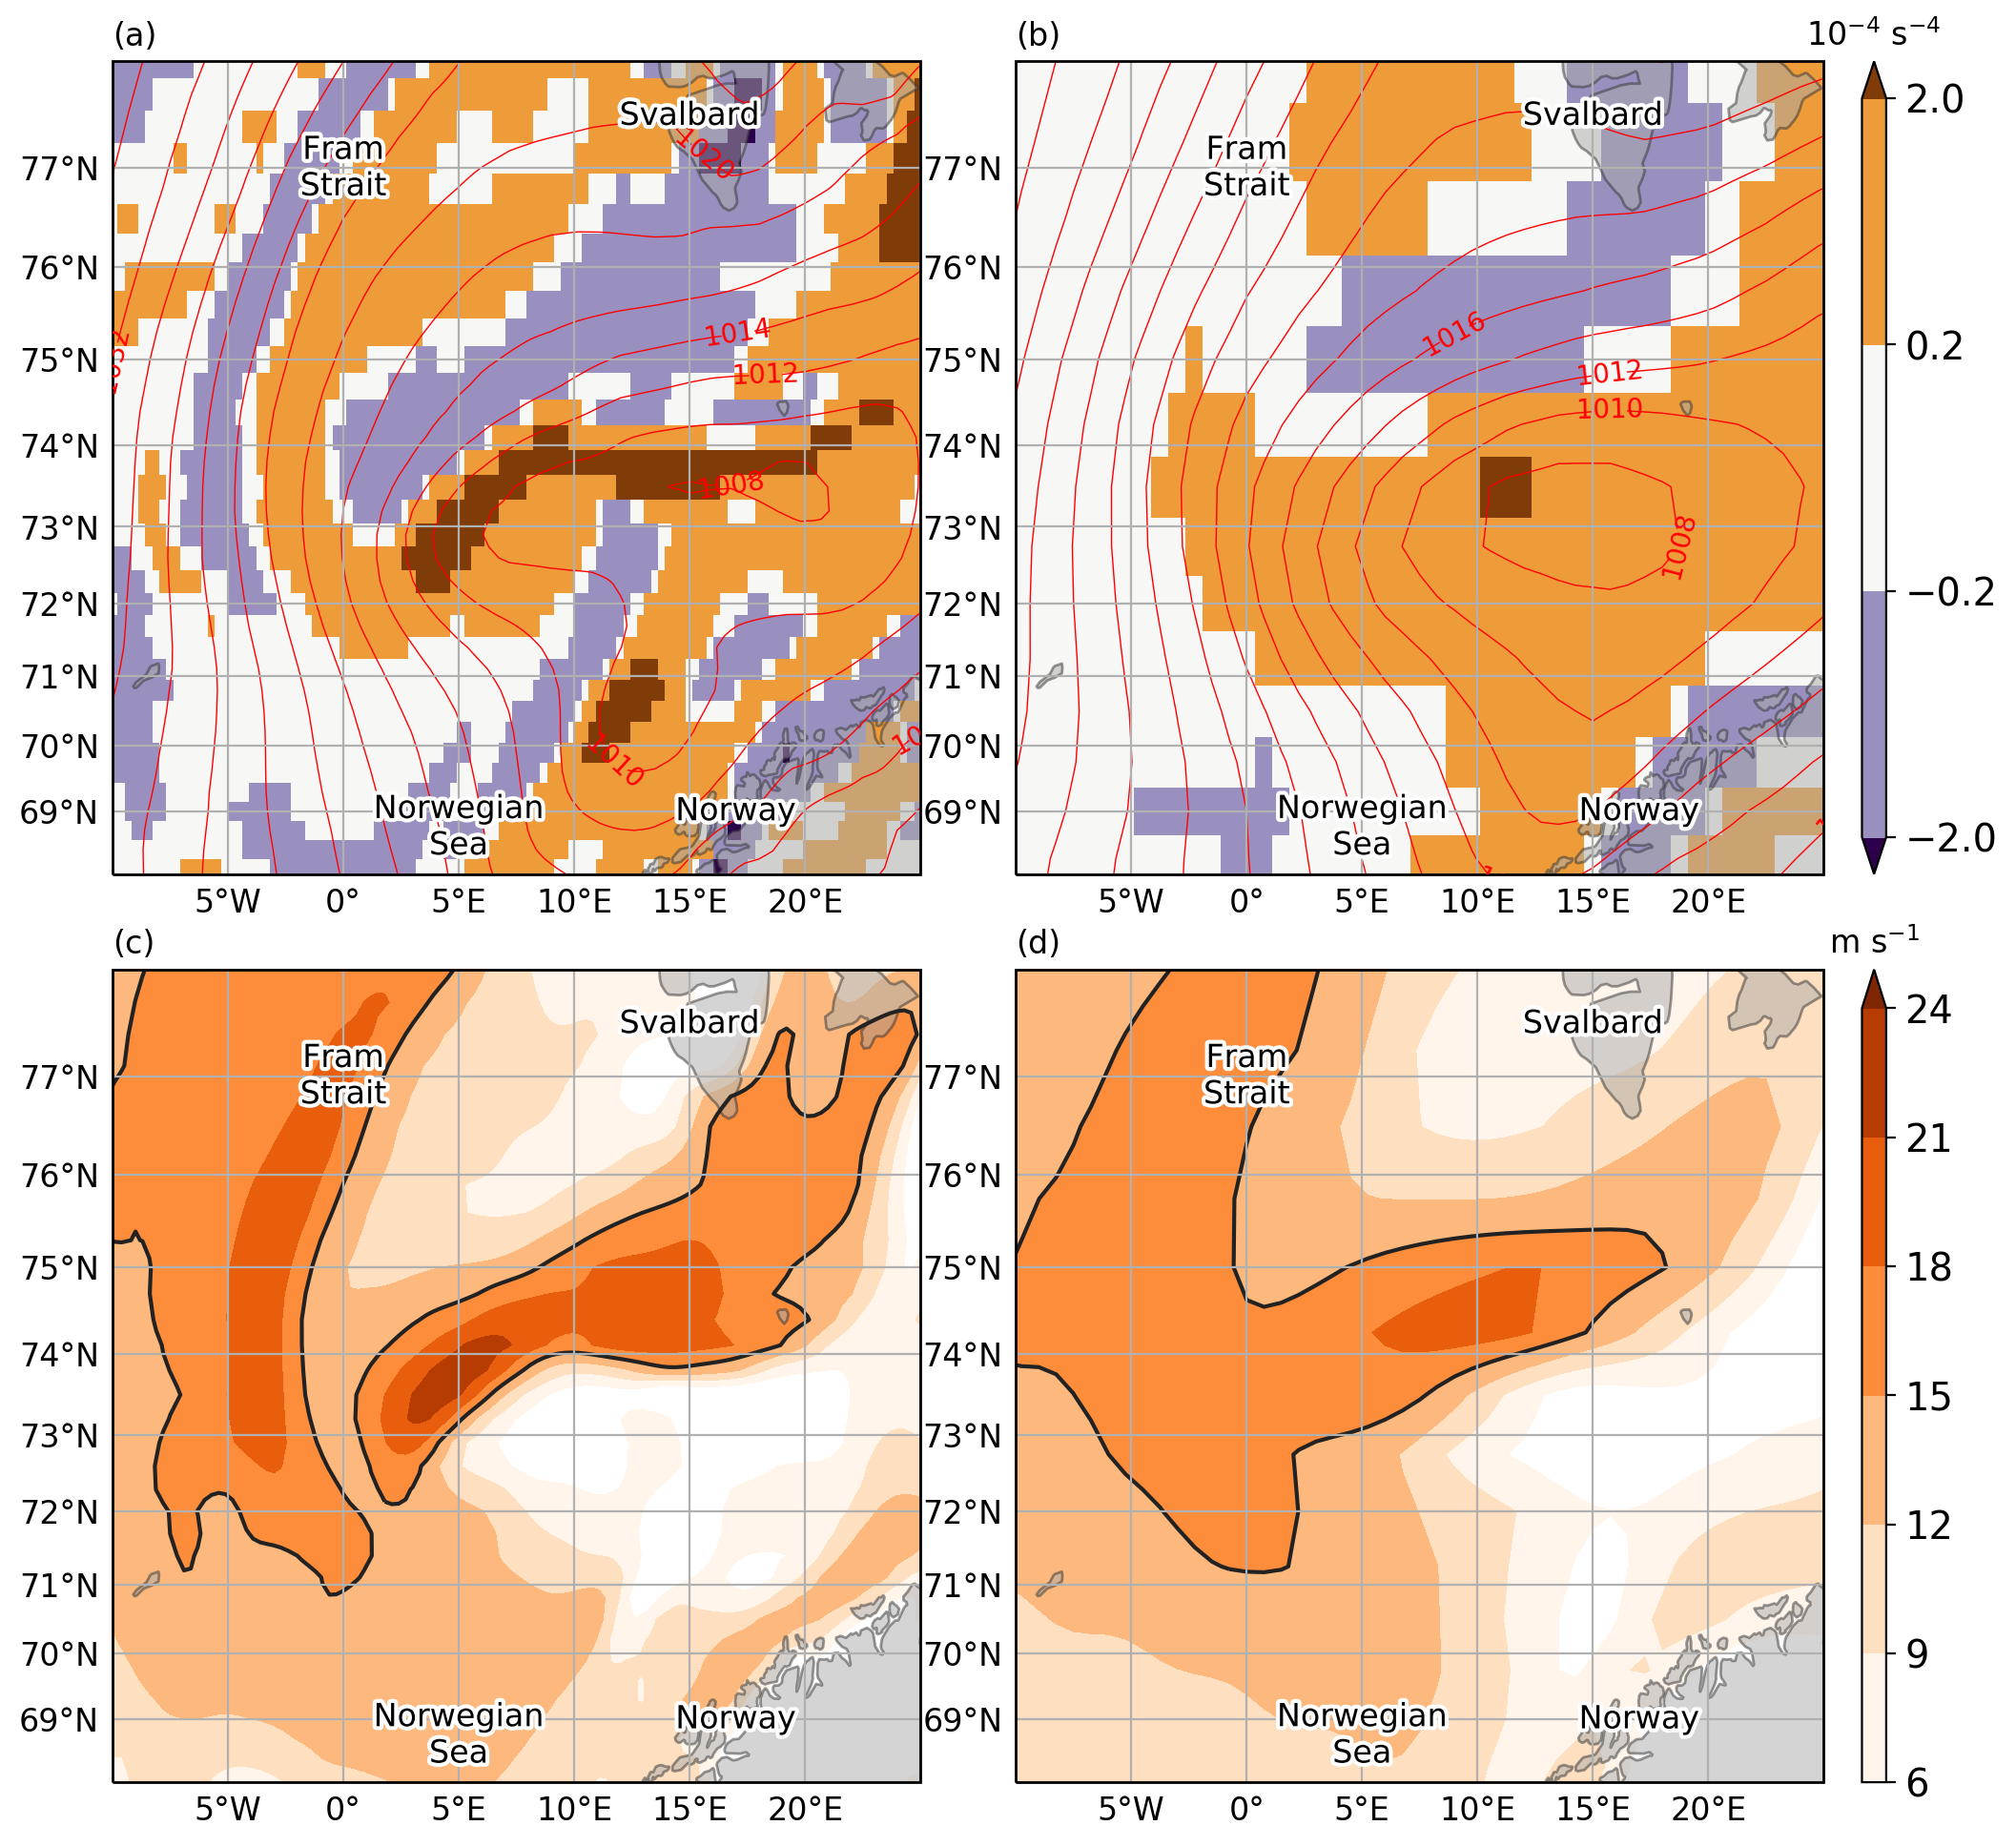

In [9]:
ncol = len(datasets)
nrow = 2

iletters = iter(string.ascii_lowercase)

fig = plt.figure(figsize=(ncol*6, nrow*6))
axgr = merc_map_grid(fig, (nrow, ncol), **MERC_KW, **AXGR_KW)

for ax in axgr.axes_all:
    ax.set_title(f'({next(iletters)})', loc='left', fontsize='medium')

for ax, dataset in zip(axgr.axes_row[0], datasets):
    vort = (dset_dict[dataset].vo.sel(time=accacia_pl_datetime, level=950) * 1e4)[::-1, :]
    slp = (dset_dict[dataset].msl.sel(time=accacia_pl_datetime) * 1e-2)[::-1, :]
    h0 = vort.plot.pcolormesh(ax=ax, **trans,
                               add_colorbar=False,
                               add_labels=False,
                               levels=[-2, -0.2, 0.2, 2],
                               cmap=cmap,
                               rasterized=True,
                               extend='both') 

    c = slp.plot.contour(ax=ax, **trans,
                          add_colorbar=False,
                          add_labels=False,
                          colors='r',
                          linewidths=0.5,
                          levels=np.arange(800, 1100, 2))
    ax.clabel(c, fmt='%4.0f', colors='r', fontsize='small')
    
for ax, dataset in zip(axgr.axes_row[1], datasets):
    u = dset_dict[dataset].u.sel(time=accacia_pl_datetime, level=975)[::-1, :]
    v = dset_dict[dataset].v.sel(time=accacia_pl_datetime, level=975)[::-1, :]
    wspd = ((u**2 + v**2 )**0.5)
    h1 = wspd.plot.contourf(ax=ax, **trans,
                            add_colorbar=False,
                            add_labels=False,
                            levels=np.arange(6, 27, 3),
                            cmap='Oranges',
                            extend='max')
    
    hh = wspd.plot.contour(ax=ax, **trans,
                           add_colorbar=False,
                           add_labels=False,
                           levels=[15],
                           colors='#222222')
#     if dataset == 'era5':
#         xstride = 1
#         ystride = 1
#     else:
#         xstride = 1
#         ystride = 1
#     p = ax.quiver(u.longitude[::xstride], u.latitude[::ystride],
#                   u.values[::ystride, ::xstride], v.values[::ystride, ::xstride], scale=300, **trans)

cb = fig.colorbar(h0, cax=axgr.cbar_axes[0])
cb.ax.set_title('$10^{-4}$ $s^{-4}$', fontsize='medium')
cb.ax.tick_params(labelsize='large')
cb = fig.colorbar(h1, cax=axgr.cbar_axes[1])
cb.ax.set_title('$m$ $s^{-1}$', fontsize='medium')
cb.ax.tick_params(labelsize='large')


for ax in axgr:
    label_map(ax, _toponyms, **trans, **text_kw)
    ax.tick_params(labelsize='xx-small')

In [10]:
fig.savefig(mypaths.plotdir / f'era5_vs_interim_accacia_case_vort_wspd')